
# 📓 Colab: 스팸 분류 LLM 파이프라인 (index, text, label=ham/spam)
- **데이터 포맷:** `index, text, label` (`label`은 ham 또는 spam)
- **기본 모델:** `klue/roberta-base` (한국어 중심)
- **환경:** Colab GPU 권장 (`런타임 → 런타임 유형 변경 → GPU`)

> 이 노트북은 데이터 로드 → 전처리 → 학습 → 평가 → 저장 → 추론 전체 과정을 포함합니다.


## 1) 필수 라이브러리 설치

In [15]:
# 0) 선택: 캐시 깨끗하게
%pip cache purge

# 1) LLM에 불필요하고 충돌 유발하는 패키지 제거
%pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless gcsfs umap-learn tensorflow

# 2) 핵심 하위 라이브러리 버전 고정 (LLM 스택 기준)
%pip install -U "numpy==1.26.4" "fsspec==2024.3.1" "scikit-learn==1.5.1"

# 3) 우리 노트북 의존성 설치 (가급적 그대로)
%pip install -U transformers==4.43.3 datasets==2.19.1 accelerate==0.33.0 evaluate==0.4.2 matplotlib==3.9.0 pandas==2.2.2

# 4) 검증
!pip check

Files removed: 22
ipython 7.34.0 requires jedi, which is not installed.
tf-keras 2.19.0 requires tensorflow, which is not installed.
tensorflow-decision-forests 1.12.0 requires tensorflow, which is not installed.
dopamine-rl 4.1.2 requires opencv-python, which is not installed.
dopamine-rl 4.1.2 requires tensorflow, which is not installed.
albucore 0.0.24 requires opencv-python-headless, which is not installed.
albumentations 2.0.8 requires opencv-python-headless, which is not installed.
tensorflow-text 2.19.0 requires tensorflow, which is not installed.
bigframes 2.24.0 requires gcsfs, which is not installed.
thinc 8.3.6 has requirement numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4.


The `ValueError` related to `numpy.dtype` size suggests a binary incompatibility issue, likely due to conflicting versions of libraries like `numpy` and `scikit-learn`. Even after attempting to fix the versions, the error persists. This might be due to residual conflicting packages or dependencies.

In [17]:
# Re-installing libraries with specific versions to ensure compatibility
%pip uninstall -y numpy scikit-learn pandas torch transformers datasets accelerate evaluate matplotlib

%pip install -U "numpy==1.26.4" "fsspec==2024.3.1" "scikit-learn==1.5.1" "pandas==2.2.2" "torch==2.8.0" "transformers==4.43.3" "datasets==2.19.1" "accelerate==0.33.0" "evaluate==0.4.2" "matplotlib==3.9.0"

!pip check

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scikit-learn 1.5.1
Uninstalling scikit-learn-1.5.1:
  Successfully uninstalled scikit-learn-1.5.1
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: transformers 4.43.3
Uninstalling transformers-4.43.3:
  Successfully uninstalled transformers-4.43.3
Found existing installation: datasets 2.19.1
Uninstalling datasets-2.19.1:
  Successfully uninstalled datasets-2.19.1
Found existing installation: accelerate 0.33.0
Uninstalling accelerate-0.33.0:
  Successfully uninstalled accelerate-0.33.0
Found existing installation: evaluate 0.4.2
Uninstalling evaluate-0.4.2:
  Successfully uninstalled evaluate-0.4.2
Found existing installation: matplotlib 3.9.

ipython 7.34.0 requires jedi, which is not installed.
tf-keras 2.19.0 requires tensorflow, which is not installed.
tensorflow-decision-forests 1.12.0 requires tensorflow, which is not installed.
dopamine-rl 4.1.2 requires opencv-python, which is not installed.
dopamine-rl 4.1.2 requires tensorflow, which is not installed.
albucore 0.0.24 requires opencv-python-headless, which is not installed.
albumentations 2.0.8 requires opencv-python-headless, which is not installed.
tensorflow-text 2.19.0 requires tensorflow, which is not installed.
bigframes 2.24.0 requires gcsfs, which is not installed.
thinc 8.3.6 has requirement numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4.


After the reinstallation, I will re-run the data loading and splitting cell to see if the error is resolved.

## 2) 데이터 불러오기 (업로드 또는 구글 드라이브)

In [2]:
import os, pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch, random

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# ==== [옵션 A] 파일 업로드로 불러오기 ====
from google.colab import files
up = files.upload()
csv_path = list(up.keys())[0]

# ==== [옵션 B] 구글 드라이브에서 불러오기 ====
# from google.colab import drive
# drive.mount('/content/drive')
# csv_path = "/content/drive/MyDrive/Colab Notebooks/dataset.csv"

# csv_path = "dataset.csv"  # 예시

df = pd.read_csv(csv_path)
df = df.rename(columns={c: c.strip().lower() for c in df.columns})
assert set(['text','label']).issubset(df.columns), f"CSV에 'text','label' 컬럼이 필요합니다. 현재: {df.columns.tolist()}"

df['label'] = df['label'].str.strip().str.lower().map({'ham':0,'spam':1})
df = df.dropna(subset=['text','label']).reset_index(drop=True)
print("라벨 분포:", df['label'].value_counts().to_dict())
df.head()

Saving korean_emails_subjects_1000.csv to korean_emails_subjects_1000 (5).csv
라벨 분포: {0: 700, 1: 300}


,id,text,label
0,1,회의 자료 업데이트 공유,0
1,2,회의록 배포: 주간회의,0
2,3,출장 계획서 검토 요청 (광주),0
3,4,[리마인드] 교육 세션 참석 안내,0
4,5,오늘만 특가 50%! 게이밍 키보드 마지막 찬스,1


### (선택) 예시 데이터 생성 (테스트용)

In [ ]:

example_rows = [
    [1, "zbawoo2k@gmail.com 관련 보안 경고", "ham"],
    [2, "[YBM/한국TOEIC위원회] 개인정보 이용내역 안내", "ham"],
    [3, "구름 이용약관 개정 안내 (2025년 10월 30일 시행)", "ham"],
    [4, "[도서관] 중요! 도서관 홈페이지 비밀번호 변경 필수 안내", "ham"],
    [5, "(광고) 오직 여기서만 이가격! 당뇨 환자분 건강생활 필수품 하루 한병 당티", "spam"],
    [6, "[라프텔] 회원 개인정보 이용∙제공 내역 안내", "ham"],
    [7, "(광고)(콜로소) 이번 추석 연휴 안하면 후회하는 3가지", "spam"],
    [8, "[공지] 근로계약서 서명 안내", "ham"],
    [9, "[TRAITHON] 멘토링 진행 방식 및 OT 자료 안내", "ham"],
    [10, "전우님 재단법인 한국데이터산업진흥원 결제 내역입니다", "ham"],
]
pd.DataFrame(example_rows, columns=["index","text","label"]).to_csv("sample_dataset.csv", index=False, encoding="utf-8")
print("샘플 데이터셋 생성 완료 → sample_dataset.csv")


## 3) 학습/검증/테스트 분할

In [3]:

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=SEED, stratify=df['label'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['label'])
print(len(train_df), len(valid_df), len(test_df))


700 150 150


## 4) 토크나이저 및 데이터셋 변환

In [4]:

from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict

model_name = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, max_length=256)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df[['text','label']]),
    "validation": Dataset.from_pandas(valid_df[['text','label']]),
    "test": Dataset.from_pandas(test_df[['text','label']])
})

tokenized = ds.map(tokenize, batched=True, remove_columns=['text'])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

## 5) 모델 학습

https://viewers.tistory.com/95 허깅페이스의 Evaluate 라이브러리 오류 발생 시 해결 방법

In [6]:
# Reinstall the evaluate library
%pip uninstall -y evaluate
%pip install -U evaluate==0.4.0 # Install the specified version

!pip check

Found existing installation: evaluate 0.4.2
Uninstalling evaluate-0.4.2:
  Successfully uninstalled evaluate-0.4.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.8 MB/s eta 0:00:00


ipython 7.34.0 requires jedi, which is not installed.
tf-keras 2.19.0 requires tensorflow, which is not installed.
tensorflow-decision-forests 1.12.0 requires tensorflow, which is not installed.
dopamine-rl 4.1.2 requires opencv-python, which is not installed.
dopamine-rl 4.1.2 requires tensorflow, which is not installed.
albucore 0.0.24 requires opencv-python-headless, which is not installed.
albumentations 2.0.8 requires opencv-python-headless, which is not installed.
tensorflow-text 2.19.0 requires tensorflow, which is not installed.
bigframes 2.24.0 requires gcsfs, which is not installed.
thinc 8.3.6 has requirement numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4.


In [5]:

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate, numpy as np

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"]
    }

args = TrainingArguments(
    output_dir="/content/spam_cls",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.003053,1.000000,1.000000
2,No log,0.001346,1.000000,1.000000
3,No log,0.001155,1.000000,1.000000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=132, training_loss=0.07432650074814305, metrics={'train_runtime': 426.8072, 'train_samples_per_second': 4.92, 'train_steps_per_second': 0.309, 'total_flos': 15500941159920.0, 'train_loss': 0.07432650074814305, 'epoch': 3.0})

Now that the model is trained, we can evaluate its performance on the test set.

## 6) 평가 및 혼동행렬

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


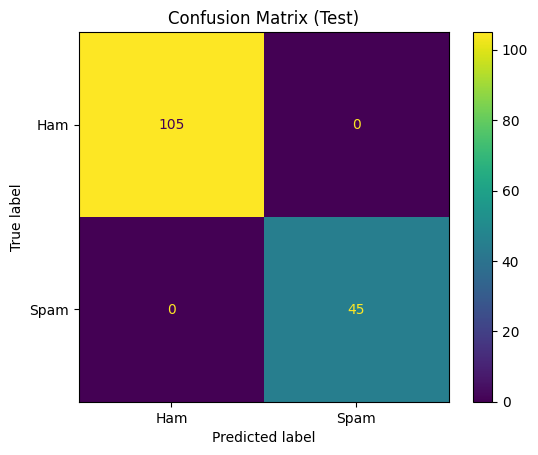

In [6]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

preds = trainer.predict(tokenized["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham","Spam"])
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.show()


## 7) 추론 예시

In [8]:

def predict_spam(texts):
    enc = tokenizer(texts, truncation=True, padding=True, max_length=256, return_tensors="pt").to(model.device)
    with torch.no_grad():
        probs = torch.softmax(model(**enc).logits, dim=1)[:,1].cpu().numpy()
    return [{"text": t, "spam_prob": float(p), "pred": "spam" if p>0.5 else "ham"} for t,p in zip(texts, probs)]

samples = [
    "zbawoo2k@gmail.com 관련 보안 경고",
    "[YBM/한국TOEIC위원회] 개인정보 이용내역 안내"
    ,"구름 이용약관 개정 안내 (2025년 10월 30일 시행)"
    ,"[도서관] ★중요★ 도서관 홈페이지 비밀번호 변경 필수 안내"
    ,"[라프텔] 회원 개인정보 이용∙제공 내역 안내"
    , "(광고)(콜로소) 📌이번 추석 연휴 안하면 후회하는 3가지"
    , "[TRAITHON] 멘토링 진행 방식 디스코드 채널 이용 및 OT 자료 업데이트 안내"
]
predict_spam(samples)


[{'text': 'zbawoo2k@gmail.com 관련 보안 경고',
  'spam_prob': 0.003847316140308976,
  'pred': 'ham'},
 {'text': '[YBM/한국TOEIC위원회] 개인정보 이용내역 안내',
  'spam_prob': 0.00281887617893517,
  'pred': 'ham'},
 {'text': '구름 이용약관 개정 안내 (2025년 10월 30일 시행)',
  'spam_prob': 0.005775937344878912,
  'pred': 'ham'},
 {'text': '[도서관] ★중요★ 도서관 홈페이지 비밀번호 변경 필수 안내',
  'spam_prob': 0.9953461289405823,
  'pred': 'spam'},
 {'text': '[라프텔] 회원 개인정보 이용∙제공 내역 안내',
  'spam_prob': 0.007675112225115299,
  'pred': 'ham'},
 {'text': '(광고)(콜로소) 📌이번 추석 연휴 안하면 후회하는 3가지',
  'spam_prob': 0.26842236518859863,
  'pred': 'ham'},
 {'text': '[TRAITHON] 멘토링 진행 방식 디스코드 채널 이용 및 OT 자료 업데이트 안내',
  'spam_prob': 0.9905970692634583,
  'pred': 'spam'}]